In [1]:
import sqlite3
import time

start_time = time.time()

conn = sqlite3.connect('/home/pi/hdd_drive/pavlovsk_doc/bd/raspi_doc.db')
cur = conn.cursor()

ins = 'SELECT Genset1_Act_power as G1, Genset2_Act_power as G2, Genset3_Act_power as G3, Genset4_Act_power as G4, Genset5_Act_power as G5 FROM g_val'
cur.execute(ins)
data = cur.fetchall()
cur.close()
conn.close()

print(time.time() - start_time)

data

0.048829078674316406


[(438, 444, 0, 0, 0),
 (441, 445, 0, 0, 0),
 (442, 449, 0, 0, 0),
 (441, 449, 0, 0, 0),
 (441, 447, 0, 0, 0),
 (444, 444, 0, 0, 0),
 (439, 445, 0, 0, 0),
 (436, 443, 0, 0, 0),
 (445, 444, 0, 0, 0),
 (436, 438, 0, 0, 0),
 (428, 427, 0, 0, 0),
 (428, 429, 0, 0, 0),
 (428, 429, 0, 0, 0),
 (425, 425, 0, 0, 0),
 (416, 424, 0, 0, 0),
 (427, 430, 0, 0, 0),
 (423, 429, 0, 0, 0),
 (424, 425, 0, 0, 0),
 (422, 416, 0, 0, 0),
 (429, 431, 0, 0, 0),
 (422, 414, 0, 0, 0),
 (430, 423, 0, 0, 0),
 (438, 438, 0, 0, 0),
 (446, 445, 0, 0, 0),
 (440, 442, 0, 0, 0),
 (434, 434, 0, 0, 0),
 (429, 426, 0, 0, 0),
 (430, 430, 0, 0, 0),
 (425, 425, 0, 0, 0),
 (421, 422, 0, 0, 0),
 (441, 438, 0, 0, 0),
 (445, 442, 0, 0, 0),
 (451, 449, 0, 0, 0),
 (448, 452, 0, 0, 0),
 (427, 427, 0, 0, 0),
 (426, 427, 0, 0, 0),
 (424, 421, 0, 0, 0),
 (426, 423, 0, 0, 0),
 (453, 450, 0, 0, 0),
 (448, 453, 0, 0, 0),
 (428, 428, 0, 0, 0),
 (426, 432, 0, 0, 0),
 (423, 425, 0, 0, 0),
 (401, 406, 0, 0, 0),
 (408, 412, 0, 0, 0),
 (413, 410

In [2]:
a, b, c, d = [1, 2, 3, 4]
c

3

In [ ]:
import sqlite3
import time

start_time = time.time()

conn = sqlite3.connect('/home/pi/hdd_drive/pavlovsk_doc/bd/raspi_doc.db')
cur = conn.cursor()

ins = 'SELECT ambient_temp FROM g_val WHERE date_time=(SELECT max(date_time) FROM g_val)'
cur.execute(ins)
data = cur.fetchone()
cur.close()
conn.close()

print(time.time() - start_time)

data[0]

In [11]:
g3.modbus_table[463]

{'Name': 'Act power',
 'Name_in_bd': 'Act_power',
 'Dim': 'kW',
 'Type': 'Integer',
 'Len': 2,
 'Dec': '0',
 'Min': '0',
 'Max': '8276*',
 'Group': 'Gener values',
 'Prev_val': 0.0,
 'Curr_val': 0.0}

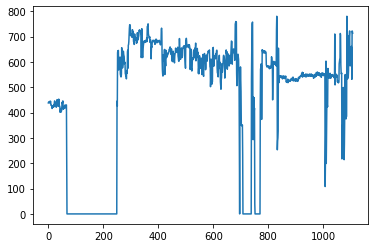

In [9]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect('/home/pi/hdd_drive/pavlovsk_doc/bd/raspi_doc.db')
df = pd.read_sql('SELECT Genset1_Act_power as G1, Genset2_Act_power as G2, Genset3_Act_power as G3, Genset4_Act_power as G4, Genset5_Act_power as G5 FROM g_val', conn)
conn.close()

plt.plot(df['G1'])

In [2]:
import doc_objects

doc_objects.mcb_open_record(g1, g2, g3, g4, g5)

In [16]:
dt = '2021-03-02 12:59:33'
ess_active_power = 24
pwrs = [650, 400, 0, 1200, 0]
pwrs.insert(0, dt)
pwrs.insert(1, ess_active_power)
pwrs

['2021-03-02 12:59:33', 24, 650, 400, 0, 1200, 0]

In [12]:
import sqlite3
import pandas as pd
import config

conn = sqlite3.connect(config.raspi_bd)
df = pd.read_sql('SELECT * FROM mcb_open_log_table', conn)
conn.close()

df

,date_time,flex_gen,genset_1,genset_2,genset_3,genset_4,genset_5
0,"2021-03-02 12:59:33,631080",24,428,0,0,0,0
1,"2021-03-02 12:59:34,005450",24,430,0,0,0,0
2,"2021-03-02 12:59:34,338856",24,427,0,0,0,0
3,"2021-03-02 12:59:34,693399",24,432,0,0,0,0
4,"2021-03-02 12:59:35,026320",24,429,0,0,0,0
5,"2021-03-02 12:59:35,371837",24,428,0,0,0,0
6,"2021-03-02 12:59:35,848654",24,428,0,0,0,0
7,"2021-03-02 12:59:36,193840",24,428,0,0,0,0
8,"2021-03-02 12:59:36,737930",24,429,0,0,0,0
9,"2021-03-02 12:59:37,259433",24,427,0,0,0,0


In [3]:
import doc_objects
import time
import config

# doc_objects.send_msg(723253749, 'Старт скрипта.')

g1 = doc_objects.Genset('/dev/ttyS0', 1)
g2 = doc_objects.Genset('/dev/ttyS0', 2)
g3 = doc_objects.Genset('/dev/ttyS0', 3)
g4 = doc_objects.Genset('/dev/ttyS0', 4)
g5 = doc_objects.Genset('/dev/ttyS0', 5)

doc = (g1, g2, g3, g4, g5)

In [9]:
import sqlite3,  config
conn = sqlite3.connect(config.raspi_bd)
curs = conn.cursor()
ins = f'SELECT * FROM {config.table_regular_values} WHERE date_time=(SELECT max(date_time) FROM {config.table_regular_values})'
curs.execute(ins)
apower = curs.fetchall()
curs.close()
conn.close()
apower


[('2021-02-27 20:39:38',
  -21,
  24.9,
  13.1,
  89,
  4.19,
  94,
  48,
  2.2,
  20,
  0,
  0,
  534,
  533,
  532,
  542,
  548,
  539,
  550,
  535,
  533,
  546,
  532,
  539,
  535,
  550,
  514,
  543,
  94,
  34.5,
  36.1,
  -3276.7,
  77.1,
  -14.8,
  1.38,
  11.2,
  31.4,
  -15.1,
  0.33,
  35.8,
  46.2,
  51.6,
  87.3,
  231,
  231,
  230,
  230,
  401,
  398,
  400,
  50,
  908,
  959,
  983,
  0.95,
  629,
  201,
  213,
  214,
  203,
  61,
  64,
  77,
  662,
  211,
  223,
  227,
  0.96,
  0.96,
  0.94,
  0,
  4,
  231,
  231,
  230,
  230,
  402,
  400,
  401,
  0,
  50,
  0,
  0,
  1500,
  537,
  550,
  514,
  8879,
  630,
  190,
  5970020,
  26,
  20.4,
  39,
  0,
  33,
  36,
  2.2,
  0,
  0,
  0,
  40,
  40,
  39,
  38,
  39,
  39,
  38,
  38,
  37,
  36,
  36,
  36,
  36,
  38,
  36,
  35,
  96,
  -1.7,
  -4.3,
  -3276.7,
  5.1,
  13.5,
  1.01,
  15.3,
  22,
  -14.1,
  0,
  16.9,
  16.9,
  16.4,
  69.3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

In [9]:
import minimalmodbus
import config
import logging
import telebot
import sqlite3
import datetime

def init_bd(doc):
    print('start init BD')
    conn = sqlite3.connect(config.raspi_bd)
    curs = conn.cursor()
    try:
        ins = f'SELECT * FROM {config.table_regular_values}'
        curs.execute(ins)
        print('успешная попытка чтения из БД, создание не требуется')
    except Exception as e:
        print(f'создание таблицы: {config.table_regular_values}')
        logging.info(f'Создание таблицы значений: {config.table_regular_values}')
        ins = f'CREATE TABLE {config.table_regular_values} (date_time VARCHAR(20) PRIMARY KEY'
        for g in doc:
            for k, v in {k: v for k, v in g.modbus_table.items() if v['Group'] in config.regular_values}.items():
                if v['Type'] == 'Integer' or v['Type'] == 'Unsigned':
                    type_field = 'INT'
                else:
                    type_field = 'CHAR (20)'
                ins += f", Genset{g.address}_{v['Name_in_bd']} {type_field}"
        ins += f')'
        curs.execute(ins)
        conn.commit()
        print(f'Таблица {config.table_regular_values} создана.')
        logging.info(f'Таблица {config.table_regular_values} создана.')
        
    curs.close()
    conn.close()
    
init_bd(doc)

start init BD
создание таблицы: g_val
Таблица g_val создана.


In [17]:
!python3 main.py

Traceback (most recent call last):
  File "main.py", line 49, in <module>
    doc_objects.fast_power_values_to_db(power_in_bd)
  File "/home/pi/Documents/PythonScripts/raspi_doc/doc_objects.py", line 484, in fast_power_values_to_db
    curs.execute(ins, pwrs)
sqlite3.OperationalError: near "VARCHAR": syntax error


In [3]:
import sqlite3
import config

conn = sqlite3.connect(config.raspi_bd)
curs = conn.cursor()
ins = f'SELECT Oil_Pressure FROM {config.table_regular_values}'
curs.execute(ins)
curs.fetchall()
curs.close()
conn.close()

OperationalError: no such column: Oil_Pressure

In [31]:
import sqlite3

table_name = 'g_val'

conn = sqlite3.connect('bd_test.bd')
curs = conn.cursor()

ins = f'CREATE TABLE {table_name} (date_time VARCHAR(20) PRIMARY KEY'
for g in doc:
    for k, v in {k: v for k, v in g.modbus_table.items() if v['Group'] in config.regular_values}.items():
        if v['Type'] == 'Integer' or v['Type'] == 'Unsigned':
            type_field = 'INT'
        else:
            type_field = 'CHAR (20)'
        ins += f", Genset{g.address}_{v['Name_in_bd']} {type_field}"
ins += f')'
print(ins)
curs.execute(ins)
conn.commit()
curs.close()
conn.close()


CREATE TABLE g_val (date_time VARCHAR(20) PRIMARY KEY, Genset1_BIN CHAR (20), Genset1_BIN_1 CHAR (20), Genset1_BIN_2 CHAR (20), Genset1_BIN_3 CHAR (20), Genset1_BIN_4 CHAR (20), Genset1_BIN_5 CHAR (20), Genset1_BIN_6 CHAR (20), Genset1_BIN_7 CHAR (20), Genset1_BIN_8 CHAR (20), Genset1_BOUT CHAR (20), Genset1_Ubat INT, Genset1_CPU_temp INT, Genset1_Engine_Temp INT, Genset1_Oil_Pressure INT, Genset1_Oil_Temp INT, Genset1_Manifold_Temp INT, Genset1_Manifold_Press INT, Genset1_Actual_Timing INT, Genset1_Desired_Timing INT, Genset1_Detonation INT, Genset1_Cylinder_1 INT, Genset1_Cylinder_2 INT, Genset1_Cylinder_3 INT, Genset1_Cylinder_4 INT, Genset1_Cylinder_5 INT, Genset1_Cylinder_6 INT, Genset1_Cylinder_7 INT, Genset1_Cylinder_8 INT, Genset1_Cylinder_9 INT, Genset1_Cylinder_10 INT, Genset1_Cylinder_11 INT, Genset1_Cylinder_12 INT, Genset1_Cylinder_13 INT, Genset1_Cylinder_14 INT, Genset1_Cylinder_15 INT, Genset1_Cylinder_16 INT, Genset1_JW_Flap_Real INT, Genset1_AIN_4_2 INT, Genset1_AC_In

In [3]:
import datetime
import sqlite3

table_name = 'g_val'

while 1:
    data = [datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')]

    ins = f'INSERT INTO {table_name} (date_time'
    ins_val = ' VALUES(?'
    for g in doc:
        for k, v in {k: v for k, v in g.modbus_table.items() if v['Group'] in config.regular_values}.items():
            ins += f", Genset{g.address}_{v['Name_in_bd']}"
            ins_val += ', ?'
            data.append(v['Curr_val'])
    ins += ') ' + ins_val + ')'
    conn = sqlite3.connect('bd_test.bd')
    curs = conn.cursor()
    curs.execute(ins, data)
    conn.commit()
    curs.close()
    conn.close()

0.5942397117614746
0.2980923652648926
0.8521709442138672
0.5733461380004883
0.5845241546630859
0.48847270011901855
0.5934090614318848
0.5679819583892822
0.349395751953125
0.11561036109924316
1.1162545680999756
0.5436370372772217
0.8439030647277832
0.7837557792663574
0.5195655822753906
0.5525031089782715
0.8202333450317383
0.5552027225494385
0.5974178314208984
0.5145959854125977
1.458832025527954
0.5394353866577148
0.6055090427398682
0.12406039237976074
0.8187446594238281
0.3805849552154541
0.6126258373260498
0.787024736404419
0.613178014755249
0.16183757781982422
0.8566813468933105
0.3748505115509033
0.7378189563751221
0.12424945831298828
0.5707008838653564
0.11289501190185547
0.8467257022857666
0.5274579524993896
0.5767834186553955
0.6072542667388916
0.5846178531646729
0.4164113998413086
0.8531076908111572
0.30951857566833496
0.5796148777008057
0.3914492130279541
1.2846033573150635
0.5366611480712891
0.6256289482116699
0.5617005825042725
0.6479995250701904
0.11356472969055176
0.560712

0.3459498882293701
0.602057933807373
0.5479917526245117
0.8154008388519287
0.7660667896270752
0.8269984722137451
0.5477263927459717
0.5639548301696777
0.5574522018432617
0.8163878917694092
0.12104105949401855
0.3516676425933838
0.3596310615539551
0.608405590057373
0.535285234451294
0.3987545967102051
0.36334919929504395
0.8955483436584473
0.4213676452636719
0.3423454761505127
0.3589913845062256
0.8402724266052246
0.5342025756835938
0.5997538566589355
0.3643820285797119
0.8795990943908691
0.591850996017456
0.5946860313415527
0.08351898193359375
1.254885196685791
0.939305305480957
0.8451845645904541
0.35920047760009766
0.8830931186676025
0.8221051692962646
0.6379215717315674
0.7774808406829834
0.6174137592315674
0.3727304935455322
0.6290509700775146
0.35962367057800293
0.6221864223480225
0.15477299690246582
0.6059155464172363
0.7665162086486816
0.8116171360015869
0.3459751605987549
0.6071505546569824
0.7831153869628906
0.8277623653411865
0.5785262584686279
0.7850263118743896
0.3359515666

KeyboardInterrupt: 

In [4]:
start_time = time.time()
for g in doc:
    g.get_update()
print((f'{time.time() - start_time:.1f} seconds'))

15.7 seconds


У меня есть массив данных, вся таблица регистров, но мне они все не нужны. Есть критерии для опроса
Надо опрашивать, только то что надо, что не надо опрашивать не надо
long опрашиваю отдельно, их не надо в пакетный опрос включать
Должны быть две группы параметров, для регулярного внесения в БД и для внесения по изменению (это статические параметры)

In [2]:
import telebot
token = '1325955552:AAHQJzvhu-IhcMpsVGX5dUsfXTJ7fFECoJs'

tb = telebot.TeleBot(token)

tb.send_message(723253749, "Hello!")